https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

In [1]:

# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers


/home/minh/anaconda3/envs/doan3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


dạng tín hiệu: 
chuẩn hóa dữ liệu: năng lượng
=> fft => tính phổ năng lượng

In [2]:
# set random seed
seed(10)
set_random_seed(10)

In [3]:
data_train = pd.read_csv('./data/data3x3htrain.csv')
data_test = pd.read_csv('./data/test3_41s.csv')

In [4]:
data_train

,X;Y;Z;Date and time;Duration
0,0.3123923416800132;-0.03515306807731822;0.1596...
1,0.1820338472248959;-0.04505592941986025;0.2235...
2,0.15343340344178347;0.0037346271647225038;0.07...
3,-0.12006301666570285;0.05458568245392881;-0.08...
4,0.06311992955198953;-0.026013178608920384;0.10...
...,...
94811,-0.05352474474921165;-0.03992926390178342;0.01...
94812,0.06031924550508899;0.06739514484291731;-0.021...
94813,-0.022497355834871446;-0.05717560510659303;0.0...
94814,-0.020553483942977124;0.048980246488866674;-0....


In [5]:
# data = data_train
# x = []
# y = []
# z = []
# for i in range(len(data)):
#     x.append(float(data['X;Y;Z;Date and time;Duration'][i].split(';')[0]))
#     y.append(float(data['X;Y;Z;Date and time;Duration'][i].split(';')[1]))
#     z.append(float(data['X;Y;Z;Date and time;Duration'][i].split(';')[2]))
        
# x = np.array(x)
# y = np.array(y)
# z = np.array(z)
# lis = []
# lis.append(x)
# lis.append(y)
# lis.append(y)
# lis = np.array(lis)
# lis = lis.transpose()
# data = pd.DataFrame(lis, columns=['x','y','z'])


In [6]:
def convert(data):    
    x = []
    y = []
    z = []
    for i in range(len(data)):
        x.append(float(data['X;Y;Z;Date and time;Duration'][i].split(';')[0]))
        y.append(float(data['X;Y;Z;Date and time;Duration'][i].split(';')[1]))
        z.append(float(data['X;Y;Z;Date and time;Duration'][i].split(';')[2]))
        
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    lis = []
    lis.append(x)
    lis.append(y)
    lis.append(z)
    lis = np.array(lis)
    lis = lis.transpose()
    data = pd.DataFrame(lis, columns=['x','y','z'])
    return data

In [7]:
data_train = convert(data_train)
data_test = convert(data_test)

In [8]:
data_train

,x,y,z
0,0.312392,-0.035153,0.159622
1,0.182034,-0.045056,0.223520
2,0.153433,0.003735,0.071466
3,-0.120063,0.054586,-0.080222
4,0.063120,-0.026013,0.109387
...,...,...,...
94811,-0.053525,-0.039929,0.013164
94812,0.060319,0.067395,-0.021467
94813,-0.022497,-0.057176,0.017523
94814,-0.020553,0.048980,-0.018270


In [9]:
data_train.iloc[1:5].values

array([[ 0.18203385, -0.04505593,  0.22351951],
       [ 0.1534334 ,  0.00373463,  0.07146631],
       [-0.12006302,  0.05458568, -0.08022156],
       [ 0.06311993, -0.02601318,  0.10938684]])

In [10]:
data_train.iloc[1:5]

,x,y,z
1,0.182034,-0.045056,0.223520
2,0.153433,0.003735,0.071466
3,-0.120063,0.054586,-0.080222
4,0.063120,-0.026013,0.109387


In [11]:
data_test.head(10)

,x,y,z
0,-0.774113,0.044771,-1.579855
1,2.774119,1.124157,0.089748
2,-0.311939,-0.338749,0.679410
3,-1.647358,-0.518574,-0.287356
4,1.979895,0.922337,0.156416
5,-1.119688,-0.724932,1.132203
6,-0.108175,0.531977,-1.257452
7,0.197619,-0.157703,0.704893
8,-0.187155,0.412117,-1.283405
9,-0.021006,-0.209368,0.684783


In [12]:
data_test.iloc[:50,0]

0    -0.774113
1     2.774119
2    -0.311939
3    -1.647358
4     1.979895
5    -1.119688
6    -0.108175
7     0.197619
8    -0.187155
9    -0.021006
10    0.476734
11   -0.988025
12    0.656216
13    0.146553
14   -0.327766
15   -0.402533
16   -0.575495
17   -0.215586
18   -0.226850
19   -0.244411
20   -0.196545
21   -0.208516
22   -0.179367
23   -0.067320
24   -0.123811
25   -0.010970
26   -0.187301
27   -0.039338
28   -0.117141
29    0.058712
30   -0.080702
31    0.190654
32    0.101499
33   -0.005052
34    0.044198
35   -0.049853
36    0.016992
37   -0.023958
38   -0.202358
39    0.146555
40    0.055823
41   -0.092243
42   -0.291092
43    0.373474
44    0.142073
45   -0.184462
46    1.314432
47   -1.504732
48    1.909828
49   -1.497712
Name: x, dtype: float64

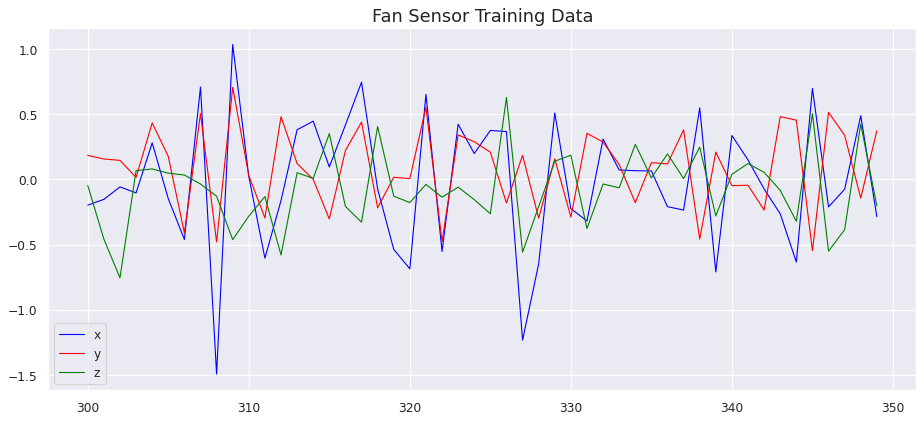

In [13]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

ax.plot(data_train.iloc[300:350,0], label='x', color='blue', animated = True, linewidth=1)
ax.plot(data_train.iloc[300:350,1], label='y', color='red', animated = True, linewidth=1)
ax.plot(data_train.iloc[300:350,2], label='z', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Fan Sensor Training Data', fontsize=16)
plt.show()

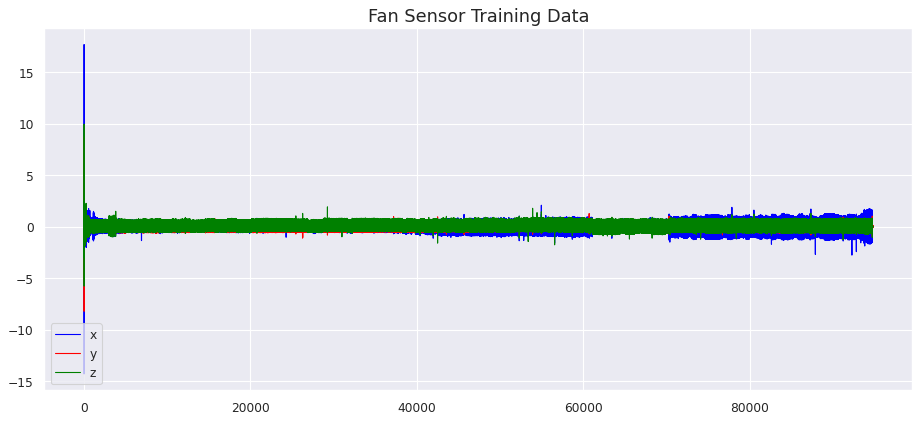

In [14]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

ax.plot(data_train.iloc[:,0], label='x', color='blue', animated = True, linewidth=1)
ax.plot(data_train.iloc[:,1], label='y', color='red', animated = True, linewidth=1)
ax.plot(data_train.iloc[:,2], label='z', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Fan Sensor Training Data', fontsize=16)
plt.show()

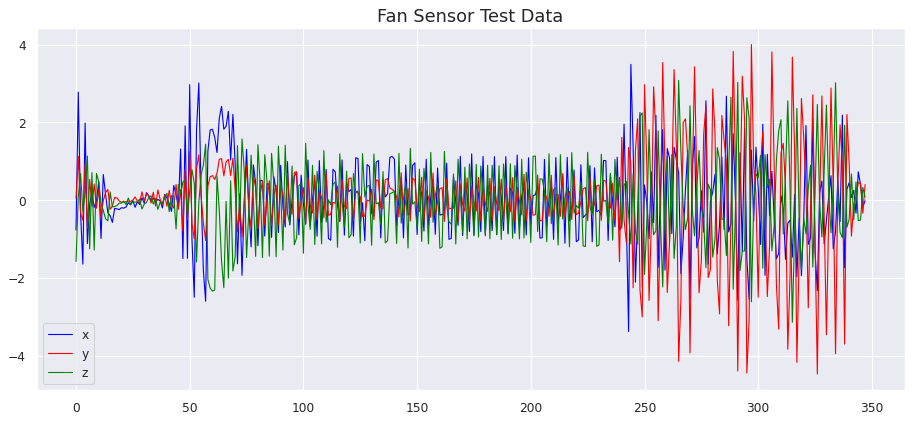

In [15]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

ax.plot(data_test.iloc[:,0], label='x', color='blue', animated = True, linewidth=1)
ax.plot(data_test.iloc[:,1], label='y', color='red', animated = True, linewidth=1)
ax.plot(data_test.iloc[:,2], label='z', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Fan Sensor Test Data', fontsize=16)
plt.show()

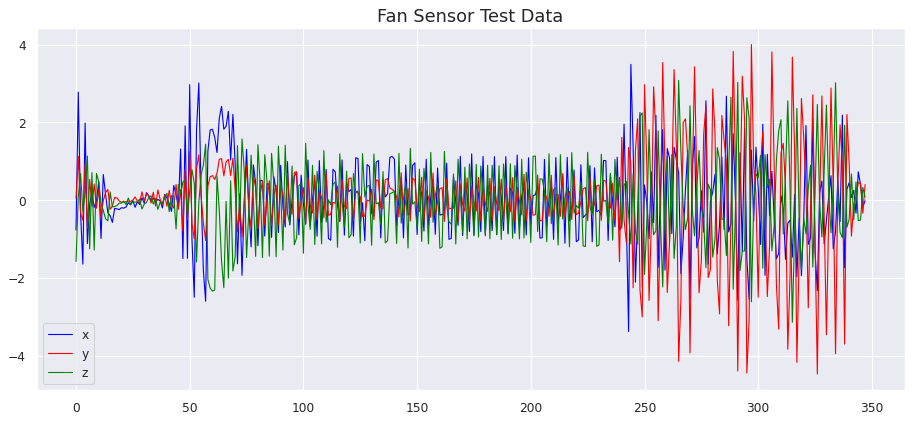

In [16]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

ax.plot(data_test.iloc[:,0], label='x', color='blue', animated = True, linewidth=1)
ax.plot(data_test.iloc[:,1], label='y', color='red', animated = True, linewidth=1)
ax.plot(data_test.iloc[:,2], label='z', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Fan Sensor Test Data', fontsize=16)
plt.show()

In [17]:
train = data_train#data_train.iloc[0: 8000]
test = data_test
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

In [18]:
train_fft.shape

(94816, 3)

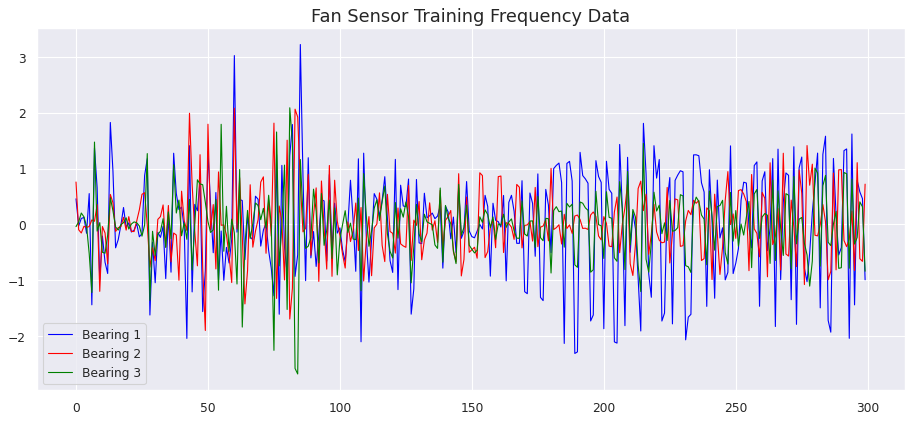

In [19]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

ax.plot(train_fft[200:500,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[200:500,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[200:500,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Fan Sensor Training Frequency Data', fontsize=16)
plt.show()

In [20]:
# train = data.iloc[0: 80000]
# test = data.iloc[80000:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (94816, 3)
Test dataset shape: (348, 3)


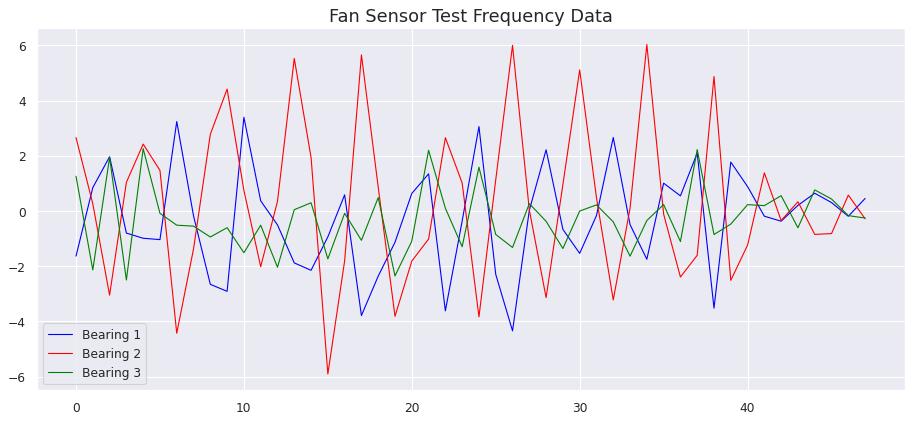

In [21]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[300:350,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[300:350,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[300:350,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Fan Sensor Test Frequency Data', fontsize=16)
plt.show()

In [22]:
# normalize the data giua 0 va 1 reshape data sao cho phu hop voi LSTM [data samples, time steps, features]
# minh co 3 feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [23]:
X_train

array([[0.45702073, 0.48288472, 0.37753576],
       [0.45294529, 0.48230066, 0.38159994],
       [0.45205114, 0.4851783 , 0.37192867],
       ...,
       [0.44655095, 0.48158585, 0.36849764],
       [0.44661172, 0.48784687, 0.36622106],
       [0.44857768, 0.48414919, 0.36763896]])

In [24]:
X_test

array([[0.4230529 , 0.48759862, 0.26689717],
       [0.5339826 , 0.55126034, 0.37309146],
       [0.43750203, 0.46497875, 0.41059666],
       ...,
       [0.45950958, 0.51030574, 0.33458484],
       [0.44178836, 0.46482499, 0.38804214],
       [0.44665432, 0.50845428, 0.37212629]])

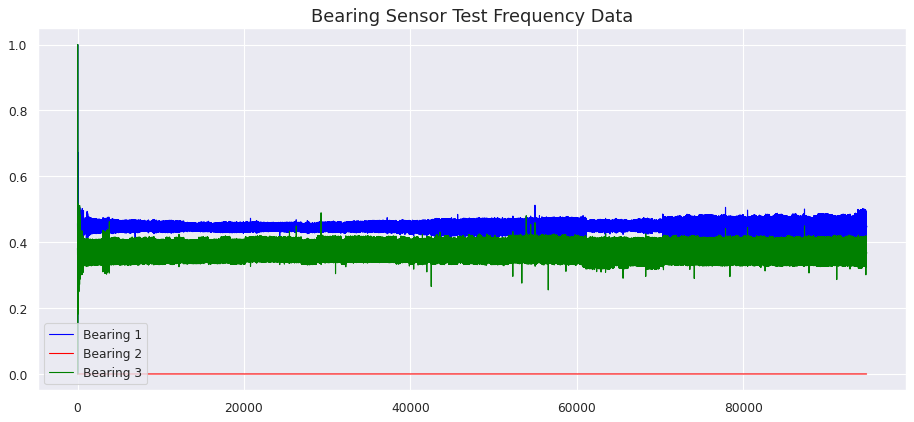

In [25]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(X_train[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(X_train[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(X_train[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

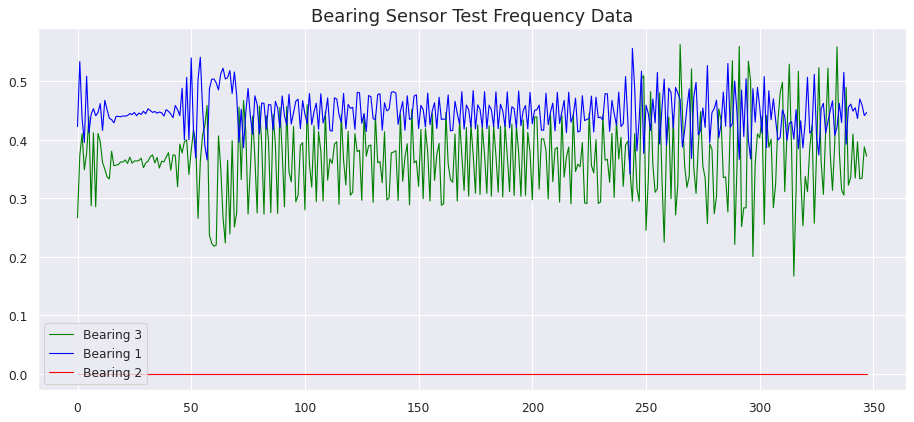

In [26]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)


ax.plot(X_test[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)

ax.plot(X_test[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(X_test[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [27]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) #86333,1,3
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (94816, 1, 3)
Test data shape: (348, 1, 3)


In [30]:
X_train.shape[2]

3

In [31]:
X_train.shape[1]

1

https://datascience.stackexchange.com/questions/66594/activation-function-between-lstm-layers 
# Activation function between LSTM layers

### Simple explanation with images

chúng ta biết rằng cần phải có hàm kích hoạt giữa các phép matranaj để trạo cho mạng neural network có khả năng mô hình hóa các model non-linear processes 

một ô LSTM cổ điển đã chứa khá nhiều hàm non-liearities: có 3 hàm `sigmoid` và một hàm `tanh` ở đây được hiển thị trong một chuỗi các ô LSTM lặp lại liên tục

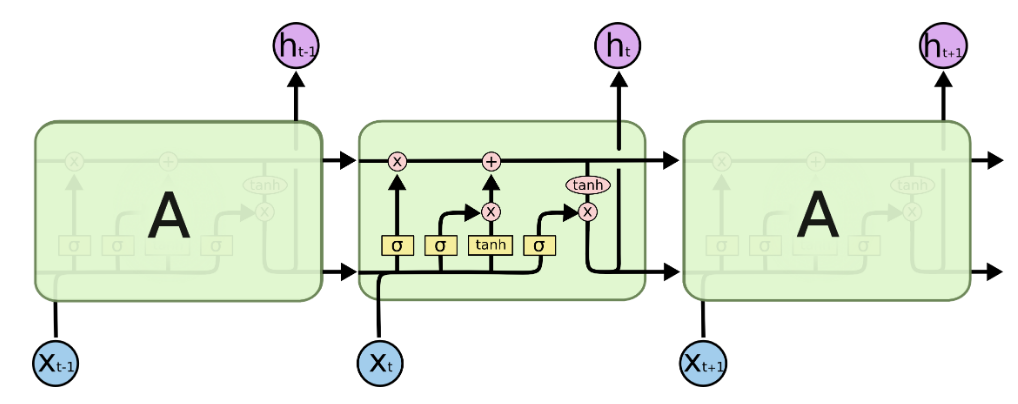

đây chỉ là một lớp LSTM duy nhất và ở đây chúng ta thầy răng ô đầu ra là phép nhân của 2 hàm sigmoid và tanh. Trong trường hợp này bạn đòng ý rằng bạn ko cần thêm hàm kích hoạt vào sau mỗi ô LSTM

bạn đang nói về xếp chồng các layer lại với nhau và chúng ta đặt một hàm kích hoạt giữa các đầu ra , nhìn vào ô trung tầm của hình ở trên....

khi bạn thêm một hàm kích hoạt giữa các layer thì thây đổi cũng ko đáng kể

In [29]:
#one to many
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2) # copy vector 
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [30]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 3)              51  

In [31]:
# fit the model to the data
nb_epochs = 28
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 90075 samples, validate on 4741 samples
Epoch 1/28
90075/90075 [==============================] - 239s 3ms/step - loss: 0.0145 - val_loss: 0.0098
Epoch 2/28
90075/90075 [==============================] - 235s 3ms/step - loss: 0.0070 - val_loss: 0.0105
Epoch 3/28
90075/90075 [==============================] - 233s 3ms/step - loss: 0.0069 - val_loss: 0.0097
Epoch 4/28
90075/90075 [==============================] - 233s 3ms/step - loss: 0.0068 - val_loss: 0.0100
Epoch 5/28
90075/90075 [==============================] - 234s 3ms/step - loss: 0.0067 - val_loss: 0.0095
Epoch 6/28
90075/90075 [==============================] - 233s 3ms/step - loss: 0.0067 - val_loss: 0.0098
Epoch 7/28
90075/90075 [==============================] - 232s 3ms/step - loss: 0.0067 - val_loss: 0.0096
Epoch 8/28
90075/90075 [==============================] - 233s 3ms/step - loss: 0.0066 - val_loss: 0.0093
Epoch 9/28
90075/90075 [==============================] - 231s 3ms/step - loss: 0.0065 - val_loss: 0.00

In [32]:
model.layers[1].output

<tf.Tensor 'lstm_1/transpose_1:0' shape=(?, 1, 16) dtype=float32>

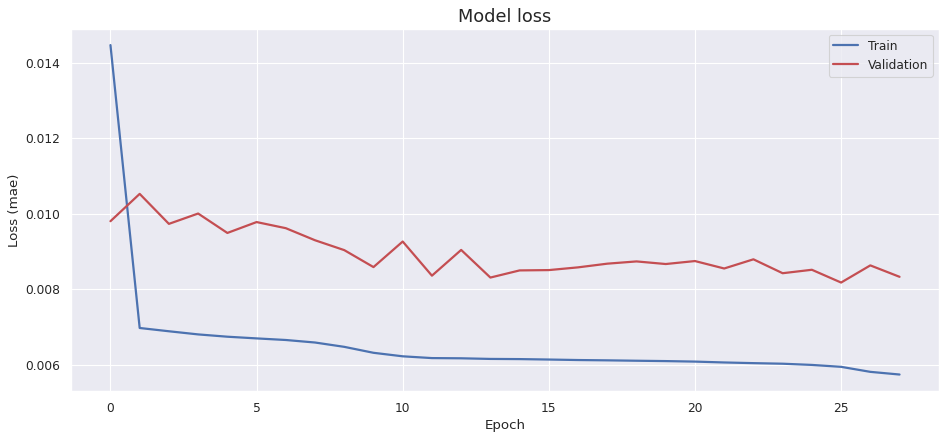

In [33]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [7]:
import h5py
model = h5py.File('./Cloud_model_1_epoch.h5', 'r')
model

<HDF5 file "Cloud_model_1_epoch.h5" (mode r)>

In [8]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

AttributeError: 'File' object has no attribute 'predict'

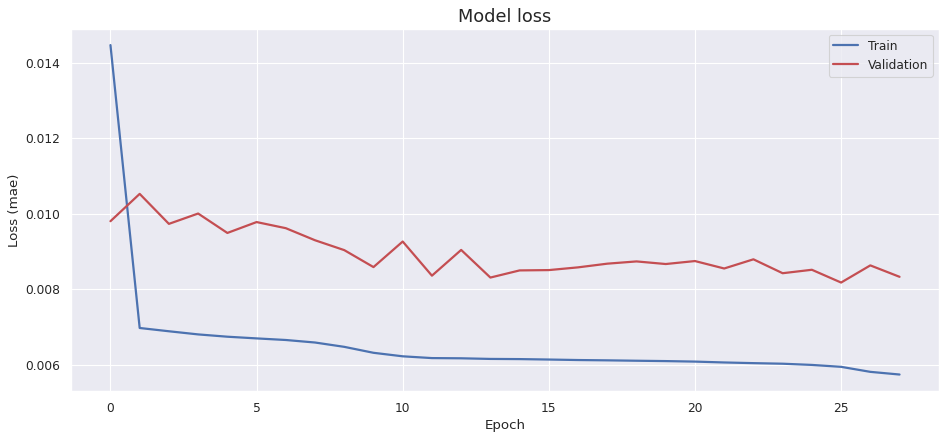

,Loss_mae,Threshold,Anomaly
0,0.004301,0.12,False
1,0.006280,0.12,False
2,0.004660,0.12,False
3,0.006259,0.12,False
4,0.005119,0.12,False


In [35]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.12
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

In [36]:
scored

,Loss_mae,Threshold,Anomaly
0,0.004301,0.12,False
1,0.006280,0.12,False
2,0.004660,0.12,False
3,0.006259,0.12,False
4,0.005119,0.12,False
...,...,...,...
5490,0.018535,0.12,False
5491,0.022067,0.12,False
5492,0.004721,0.12,False
5493,0.011618,0.12,False


In [37]:
a = 1>3
a

False

In [38]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.12
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

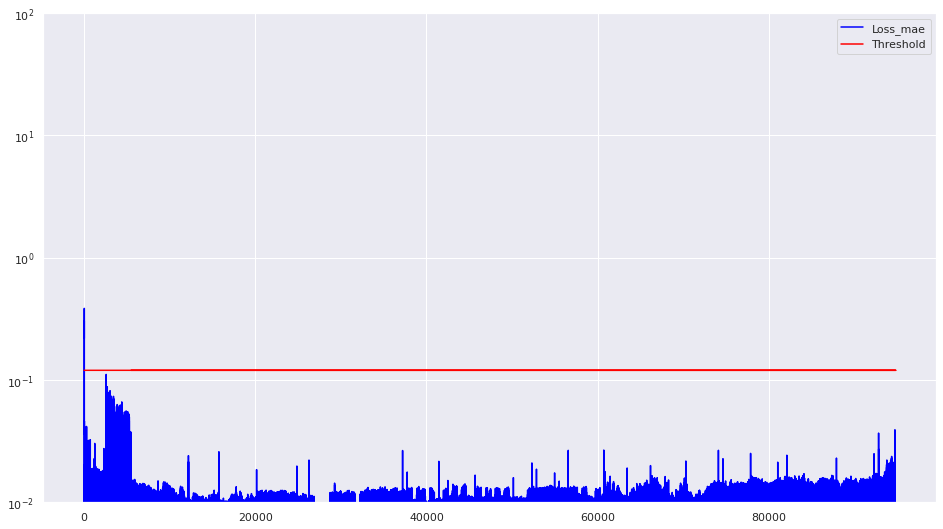

In [39]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [40]:
# save all model information, including weights, in h5 format
model.save("Cloud_model_1_epoch.h5")
print("Model saved")

Model saved
